In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import f_oneway, shapiro, levene
import itertools
import warnings
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler
from scipy.stats import chi2_contingency
import geopandas as gpd
import folium
import seaborn as sns

In [23]:
# Load the dataset
file_path = '2023-10-17-washington-post-police-shootings-export.csv'
df = pd.read_csv(file_path)

In [7]:

warnings.filterwarnings('ignore')

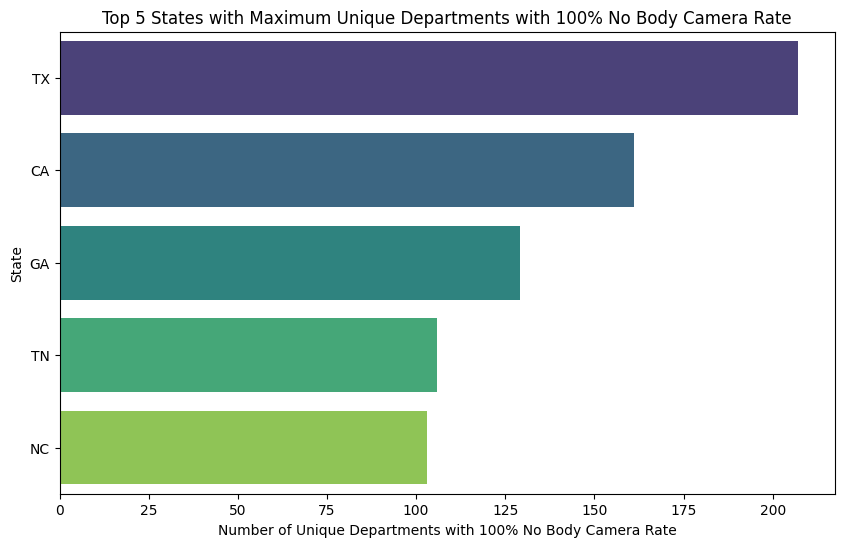

Top 5 States with Maximum Unique Departments:
state
TX    207
CA    161
GA    129
TN    106
NC    103
Name: police_department, dtype: int64


In [10]:
#Do certain police departments show a higher rate of incidents of no body camera usage?

# Split multiple police departments into separate rows
df['police_department'] = df['police_departments_involved'].str.split(';')
df = df.explode('police_department')

# Extract state from the 'police_department' column
df['state'] = df['police_department'].str.split(',').str[-1].str.strip()

# Filter incidents with no body camera usage
no_body_camera_incidents = df[df['body_camera'] == False]

# Group by unique police department identifier and state, calculate the rate of incidents with no body camera
department_no_body_camera_rate = no_body_camera_incidents.groupby(['police_department', 'state'])['body_camera'].count() / df.groupby(['police_department', 'state'])['body_camera'].count()

# Find departments with the highest rate (1.0)
highest_rate_departments = department_no_body_camera_rate[department_no_body_camera_rate == 1.0]

# Count the number of unique departments per state with the highest rate
max_departments_states = highest_rate_departments.reset_index().groupby('state')['police_department'].nunique()

# Get the top 5 states with the maximum number of unique departments
top_5_states = max_departments_states.nlargest(5)

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x=top_5_states.values, y=top_5_states.index, palette='viridis')
plt.title('Top 5 States with Maximum Unique Departments with 100% No Body Camera Rate')
plt.xlabel('Number of Unique Departments with 100% No Body Camera Rate')
plt.ylabel('State')
plt.show()

# Display the top 5 states and their corresponding number of unique departments
print('Top 5 States with Maximum Unique Departments:')
print(top_5_states)


Shapiro-Wilk Test for White: p-value = 1.8929681926494327e-26
Normality not detected for White
Shapiro-Wilk Test for Asian: p-value = 0.00999534409493208
Normality not detected for Asian
Shapiro-Wilk Test for Hispanic: p-value = 2.25740991996122e-22
Normality not detected for Hispanic
Shapiro-Wilk Test for Black: p-value = 8.179339732895038e-28
Normality not detected for Black
Shapiro-Wilk Test for Other: p-value = 0.5033304691314697
Normality detected for Other
Shapiro-Wilk Test for Unknown: p-value = 1.2972030331024812e-16
Normality not detected for Unknown
Shapiro-Wilk Test for Native American: p-value = 0.0012239518109709024
Normality not detected for Native American
Levene's Test for Homogeneity of Variances: p-value = 8.917476503322734e-54
Reject the null hypothesis. There is evidence of a significant difference in variances across groups.



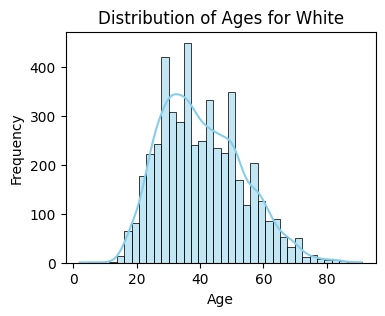

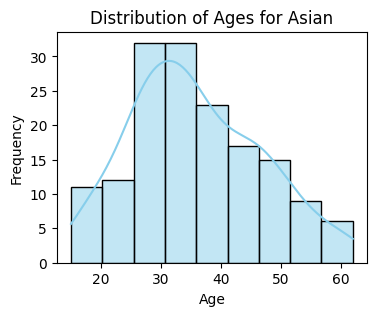

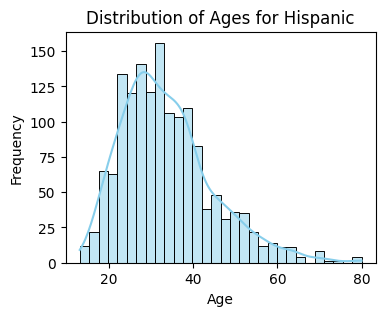

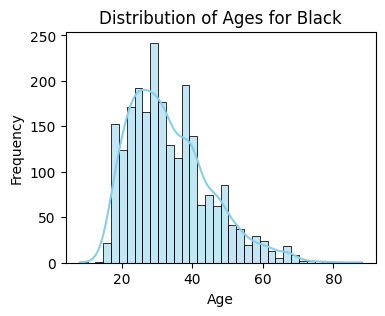

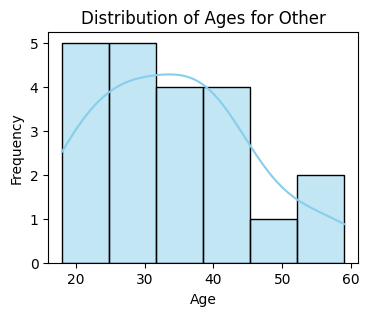

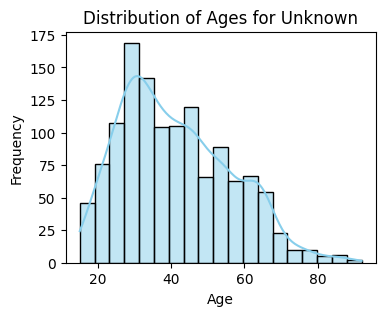

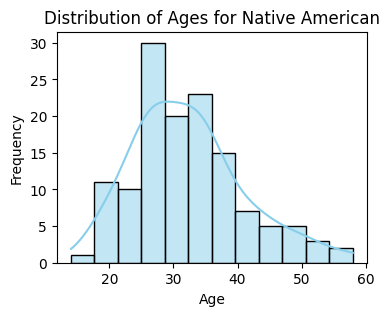

In [12]:
#Is there a difference in the mean age between different racial groups?

# Drop rows where 'age' is null
df = df.dropna(subset=['age'])

# Function to check normality and plot distribution
def check_normality_and_plot(data, race):
    stat, p_value = shapiro(data)
    print(f"Shapiro-Wilk Test for {race}: p-value = {p_value}")
    if p_value < 0.05:
        print(f"Normality not detected for {race}")
    else:
        print(f"Normality detected for {race}")
    plt.figure(figsize=(4, 3))
    sns.histplot(data, kde=True, color='skyblue')
    plt.title(f'Distribution of Ages for {race}')
    plt.xlabel('Age')
    plt.ylabel('Frequency')
    # plt.show()

# Check normality for each race
for race in df['race'].unique():
    race_data = df[df['race'] == race]['age']
    if len(race_data) >= 3:
        check_normality_and_plot(race_data, race)

# Check homogeneity of variances
valid_race_data = [df[df['race'] == race]['age'] for race in df['race'].unique() if len(df[df['race'] == race]) >= 3]
stat, p_value_levene = levene(*valid_race_data)
print(f"Levene's Test for Homogeneity of Variances: p-value = {p_value_levene}")
alpha_homogeneity = 0.05
if p_value_levene < alpha_homogeneity:
    print("Reject the null hypothesis. There is evidence of a significant difference in variances across groups.\n")
else:
    print("Fail to reject the null hypothesis. There is no significant difference in variances across groups.\n")


In [13]:
# Perform ANOVA
f_statistic, p_value = f_oneway(*valid_race_data)
print("F-statistic:", f_statistic)
print("P-value:", p_value)

if p_value < 0.05:
    print("Reject the null hypothesis. There are significant differences in ages across different races.\n")
else:
    print("Fail to reject the null hypothesis. No significant differences in ages across different races.\n")

# Perform Welch's ANOVA
f_statistic, p_value_welch = f_oneway(*valid_race_data)
print(f"Welch's ANOVA F-Statistic = {f_statistic}, p-value = {p_value_welch}")

# Interpretation
alpha_welch = 0.05
if p_value_welch < alpha_welch:
    print("Reject the null hypothesis. There is evidence of a significant difference in ages across races (Welch's ANOVA).\n")
else:
    print("Fail to reject the null hypothesis. There is no significant difference in ages across races (Welch's ANOVA).\n")

# Get unique races
unique_races = df['race'].unique()

# Calculate mean age for each race
mean_ages = {race: df[df['race'] == race]['age'].mean() for race in unique_races}

# Find and print mean age differences between each pair of races
for race1, race2 in itertools.combinations(unique_races, 2):
    mean_diff = mean_ages[race1] - mean_ages[race2]
    print(f"Mean age difference between {race1} and {race2}: {mean_diff:.2f} years")

F-statistic: 130.9859351662753
P-value: 2.4036579934736362e-160
Reject the null hypothesis. There are significant differences in ages across different races.

Welch's ANOVA F-Statistic = 130.9859351662753, p-value = 2.4036579934736362e-160
Reject the null hypothesis. There is evidence of a significant difference in ages across races (Welch's ANOVA).

Mean age difference between White and Asian: 4.71 years
Mean age difference between White and Hispanic: 6.80 years
Mean age difference between White and Black: 6.98 years
Mean age difference between White and Other: 6.49 years
Mean age difference between White and Unknown: -0.78 years
Mean age difference between White and Native American: 8.24 years
Mean age difference between White and Black,Hispanic: 13.49 years
Mean age difference between Asian and Hispanic: 2.08 years
Mean age difference between Asian and Black: 2.27 years
Mean age difference between Asian and Other: 1.78 years
Mean age difference between Asian and Unknown: -5.50 years

In [16]:
# Filter relevant columns
df_age_weapon = df[['age', 'armed']]
# Drop rows with missing values
df_age_weapon = df_age_weapon.dropna()
# Get the top N weapons by count
top_weapons = df_age_weapon['armed'].value_counts().nlargest(10).index

# Filter the dataframe for only the top weapons
df_top_weapons = df_age_weapon[df['armed'].isin(top_weapons)]

# Perform ANOVA
anova_result = f_oneway(*[df_top_weapons[df_top_weapons['armed'] == weapon]['age'] for weapon in top_weapons])

# Check p-value
p_value = anova_result.pvalue

# Print the result
print(f'ANOVA p-value: {p_value}')

# Interpret the result
if p_value < 0.05:
    print('There is a statistically significant difference in age across different weapon types.')
else:
    print('There is no statistically significant difference in age across different weapon types.')

#Log regression to predict 

# Filter relevant columns
df_age_weapon = df[['age', 'armed']].dropna()

# Encode the 'armed' column to numerical values
le = LabelEncoder()
df_age_weapon['armed_encoded'] = le.fit_transform(df_age_weapon['armed'])

# Features (X) and target variable (y)
X = df_age_weapon[['age']]
y = df_age_weapon['armed_encoded']

# Standardize the features (scaling)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Create and train a logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Ensure the number of classes in the classification report matches the number of unique classes in the original 'armed' column
unique_classes = df_age_weapon['armed'].nunique()
report = classification_report(y_test, y_pred, labels=range(unique_classes), target_names=le.classes_[:unique_classes], zero_division=1)

print(f'Accuracy: {accuracy_score(y_test, y_pred):.2f}')
print('Classification Report:')
print(report)

ANOVA p-value: 3.97628510118805e-18
There is a statistically significant difference in age across different weapon types.
Accuracy: 0.58
Classification Report:
                           precision    recall  f1-score   support

             blunt_object       1.00      0.00      0.00        42
blunt_object,blunt_object       1.00      1.00      1.00         0
       blunt_object,knife       1.00      1.00      1.00         0
                      gun       0.58      1.00      0.73       917
                gun,knife       1.00      0.00      0.00         5
              gun,vehicle       1.00      0.00      0.00        10
                    knife       1.00      0.00      0.00       290
       knife,blunt_object       1.00      0.00      0.00         1
            knife,vehicle       1.00      1.00      1.00         0
                    other       1.00      0.00      0.00        20
 other,blunt_object,knife       1.00      1.00      1.00         0
                other,gun       1.0

In [17]:
#Are there any trends in the types of arms used by different races?

# Calculate the count of different categories and missing values
total_count = len(df)
unarmed_count = df['armed'].eq('unarmed').sum()
undetermined_count = df['armed'].eq('undetermined').sum()
missing_count = df['armed'].isna().sum()

# Calculate the count of definitely armed individuals
definitely_armed_count = total_count - unarmed_count - undetermined_count - missing_count

# Calculate the percentages
definitely_armed_percentage = (definitely_armed_count / total_count) * 100
undetermined_percentage = (undetermined_count / total_count) * 100
missing_percentage = (missing_count / total_count) * 100
gun_count = df['armed'].eq('gun').sum()
gun_percentage = (gun_count / total_count) * 100

# Print the results
print(f'Definitely Armed: {definitely_armed_percentage:.2f}%')
print(f'Undetermined: {undetermined_percentage:.2f}%')
print(f'Missing data: {missing_percentage:.2f}%')
print(f'Gun: {gun_percentage:.2f}%')

Definitely Armed: 87.75%
Undetermined: 3.98%
Missing data: 2.39%
Gun: 57.96%


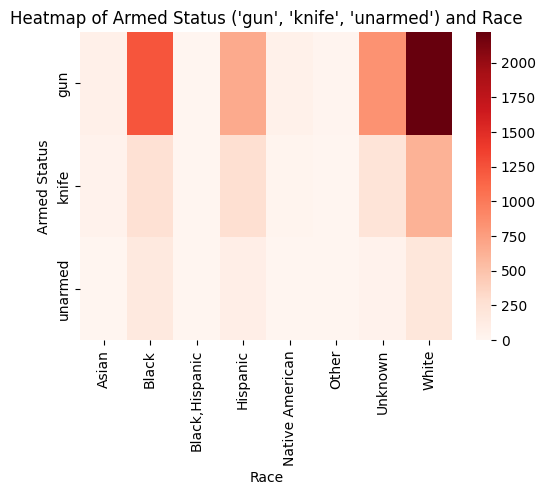

In [18]:
#Are there any trends in the types of arms used by different races?
filtered_df = df[df['armed'].isin(['gun', 'knife', 'unarmed'])]

# A cross-tabulation (contingency table) of armed and race
cross_tab = pd.crosstab(filtered_df['armed'], filtered_df['race'])

plt.figure(figsize=(6, 4))
sns.heatmap(cross_tab, cmap="Reds", annot=False, fmt='d')

plt.xlabel("Race")
plt.ylabel("Armed Status")
plt.title("Heatmap of Armed Status ('gun', 'knife', 'unarmed') and Race")
filename = f'9.png'
plt.savefig(filename)
plt.show()
plt.show()

p-value: 1.264279775240657e-32
There are statistically significant differences.


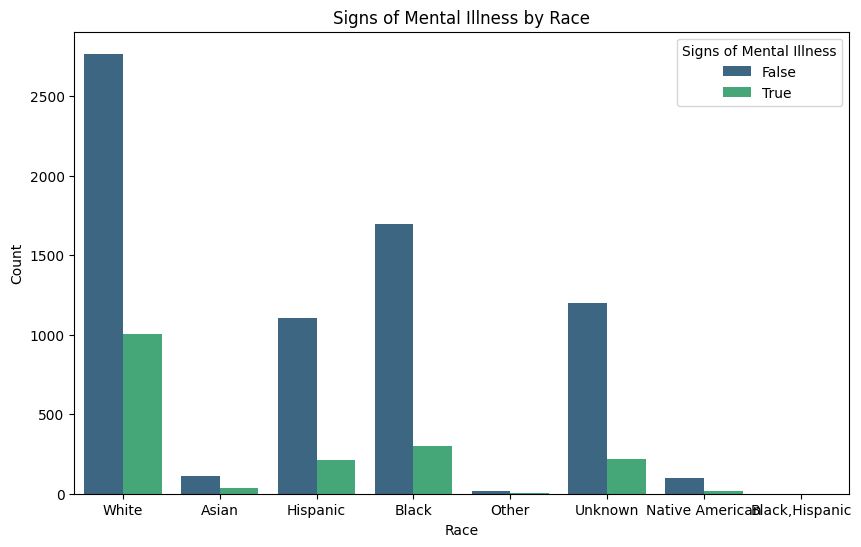

race
Asian              22.602740
Black              15.045135
Black,Hispanic      0.000000
Hispanic           16.045627
Native American    15.384615
Other              28.571429
Unknown            15.286624
White              26.617179
Name: signs_of_mental_illness, dtype: float64


In [19]:
# Are there statistically significant differences in the prevalence of mental illness indicators across different racial?
contingency_table = pd.crosstab(df['race'], df['signs_of_mental_illness'])
stat, p, dof, expected = chi2_contingency(contingency_table)
# 'stat': Chi-square statistic
# 'p': p-value indicating the probability of observing the given result by chance
# 'dof': Degrees of freedom in the test
# 'expected': Expected frequencies based on the null hypothesis
alpha = 0.05  # Set your significance level

print(f'p-value: {p}')

if p < alpha:
    print("There are statistically significant differences.")
else:
    print("There are no statistically significant differences.")
    

plt.figure(figsize=(10, 6))
sns.countplot(x='race', hue='signs_of_mental_illness', data=df, palette='viridis')

plt.title('Signs of Mental Illness by Race')
plt.xlabel('Race')
plt.ylabel('Count')

# Show the legend
plt.legend(title='Signs of Mental Illness', loc='upper right')
# Show the plot
plt.show()

# Calculate the percentage of mental illness in each race
percentage_by_race = (df.groupby('race')['signs_of_mental_illness'].sum() / df.groupby('race')['signs_of_mental_illness'].count()) * 100

# Display the results
print(percentage_by_race)



In [21]:
# Loading GeoJSON file with geometries of US states
geojson_path = 'usa-cities.geojson'
geojson_data = gpd.read_file(geojson_path)
geojson_data
# Merge the police shooting dataset with the GeoJSON file based on the state or region column
merged_df = pd.merge(geojson_data, df, how='left', left_on='STATE', right_on='state')

# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(merged_df)

# Create a folium map
m = folium.Map(location=[37.7749, -122.4194], zoom_start=4)

from folium.plugins import HeatMap
merged_df = pd.merge(geojson_data, df, how='left', left_on='STATE', right_on='state')

# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(merged_df)

# Create a folium map
m = folium.Map(location=[37.7749, -122.4194], zoom_start=4)

# Create a HeatMap layer for the police shooting incidents
heat_data = [[point.y, point.x] for point in gdf.geometry if point.y and point.x]
HeatMap(heat_data, radius=15, blur=10).add_to(m)
m.save('police_shooting_heatmap_sample.png')

             city      lat       lng  cluster
0           Aloha  45.4920 -122.8725        0
1         Shelton  41.3060  -73.1383        0
2         Shelton  47.2186 -123.1121        0
3         Shelton  40.7784  -98.7294        0
4         Wichita  37.6895  -97.3443        0
...           ...      ...       ...      ...
34637       Miami  39.3224  -93.2258        0
34640  Youngstown  41.0993  -80.6463        0
34641  Youngstown  43.2488  -79.0443        0
34642  Youngstown  40.2798  -79.3659        0
34643  Youngstown  37.6481 -119.7182        0

[33730 rows x 4 columns]
Number of clusters: 5


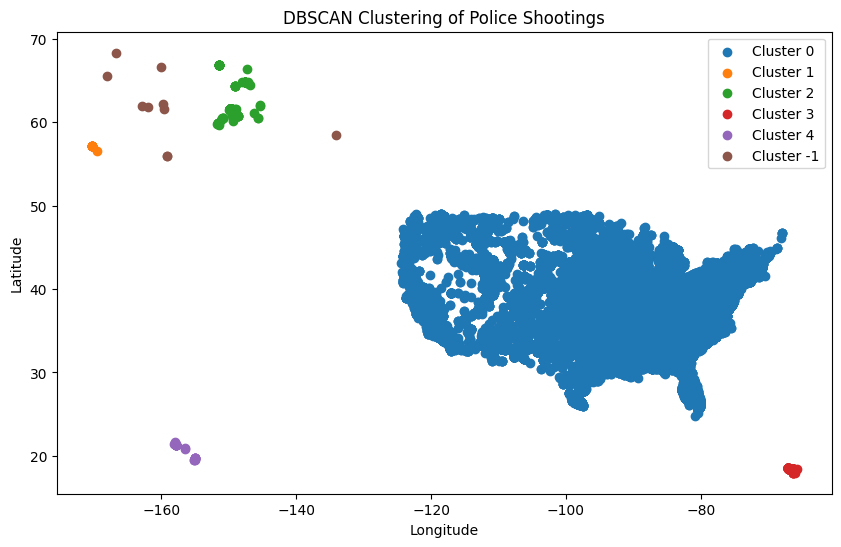

In [27]:
from sklearn.cluster import DBSCAN
#DBSCAN clusters
city_coordinates = pd.read_csv('uscities.csv')
# Merge datasets based on the 'city' column
merged_data = pd.merge(df, city_coordinates, on='city', how='left')
# Handle missing values by dropping rows with NaN values
merged_data = merged_data.dropna(subset=['lat', 'lng'])

# Extract relevant features for clustering (latitude and longitude)
features = merged_data[['lat', 'lng']]
# Scale the feature
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)
# Apply DBSCAN
epsilon = 0.5 
min_samples = 5
dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
merged_data['cluster'] = dbscan.fit_predict(scaled_features)

# Visualize the clusters or analyze them further based on your needs
print(merged_data[['city', 'lat', 'lng', 'cluster']])

# Print the number of clusters
num_clusters = len(set(dbscan.labels_)) - (1 if -1 in dbscan.labels_ else 0)
print(f"Number of clusters: {num_clusters}")

# Visualize the clusters
plt.figure(figsize=(10, 6))

# Scatter plot for each cluster
for cluster_label in set(merged_data['cluster']):
    cluster_data = merged_data[merged_data['cluster'] == cluster_label]
    plt.scatter(cluster_data['lng'], cluster_data['lat'], label=f'Cluster {cluster_label}')

plt.title('DBSCAN Clustering of Police Shootings')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()
